In [1]:
import tensorflow as tf
tf.enable_eager_execution()

In [2]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import math
import numpy as np
import matplotlib.pyplot as plt

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [3]:
tf.__version__

'1.15.3'

In [4]:
dataset, metadata = tfds.load('mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dataset mnist downloaded and prepared to /home/naivoder/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
    'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Bad argument number for Name: 3, expecting 4
    'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Bad argument number for Name: 3, expecting 4


In [5]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of Training Examples:", num_train_examples)
print("Number of Testing Examples:", num_test_examples)

Number of Training Examples: 60000
Number of Testing Examples: 10000


In [6]:
# preprocess - normalize the image data from [0,255] to [0,1]
def normalize(images, labels):
    images = tf.cast(images, tf.float16)
    images /= 255
    return images, labels

# apply normalize function to entire dataset
train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

# cache images after loading from disk for faster training
train_dataset = train_dataset.cache()
test_dataset = test_dataset.cache()

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu, input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])


In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [9]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [10]:
model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Train for 1875 steps
Epoch 1/10
1875/1875 [==============================] - 12s 6ms/step - loss: 1.5257 - acc: 0.9382
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 1.4834 - acc: 0.9783
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 1.4782 - acc: 0.9835
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 1.4749 - acc: 0.9864
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 1.4734 - acc: 0.9877
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 1.4728 - acc: 0.9884
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 1.4717 - acc: 0.9895
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 1.4710 - acc: 0.9904
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 1.4701 - acc: 0.9911
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 1.4701 - acc: 0.9911


In [11]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 2s 5ms/step - loss: 1.4758 - acc: 0.9852
Accuracy on test dataset: 0.9852


In [12]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [13]:
predictions.shape

(32, 10)

In [14]:
predictions[0]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [15]:
np.argmax(predictions[0])

2

In [18]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(int(predicted_label),
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

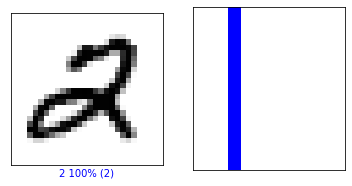

In [19]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

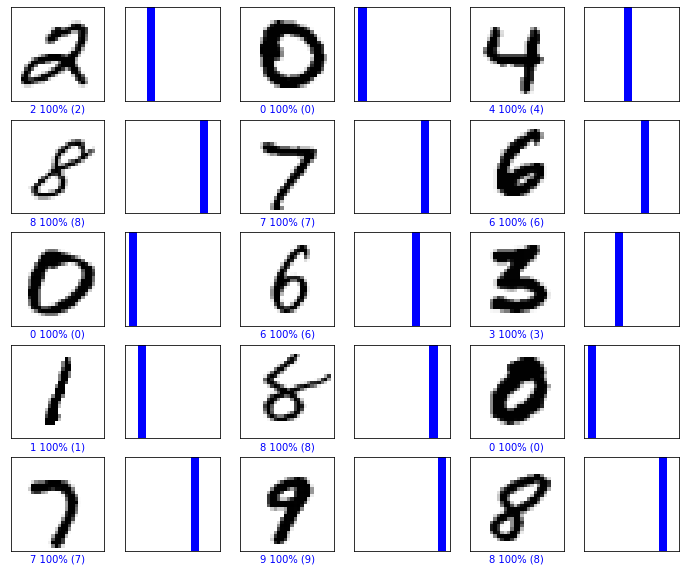

In [20]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)


In [21]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28, 1)


In [22]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


In [23]:
predictions_single = model.predict(img)

print(predictions_single)

[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


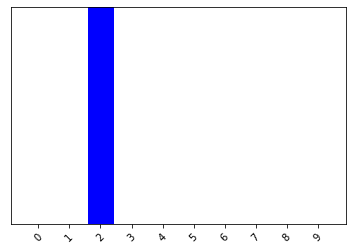

In [25]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), range(10), rotation=45)

In [27]:
np.argmax(predictions_single[0])

2

In [29]:
export_path = "../mnist_digits.h5"
print(export_path)

./mnist_digits.h5


In [30]:
model.save(export_path)

In [32]:
import pandas as pd

In [35]:
test = pd.read_csv("../../kaggle/datasets/mnist_digits/test.csv")

In [37]:
test = test / 255.0
test = test.values.reshape(-1,28,28,1)

In [38]:
results = model.predict(test)

In [40]:
results = np.argmax(results, axis=1)
results = pd.Series(results, name='Label')

In [41]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("mnist_digits.csv",index=False)